# EP Model

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simulate_FG(x):
    """Simulate a field goal given a state x in the form of a list, where 
    item 0 is the Down, item 1 the field position,item 2 the yards to go,
    and item 3 the possession (-1 or 1).
    Return an updated state based on whether or not the field goal was 
    successful"""
    FP = x[2]
    POS = x[3]
    kick_length = 100 - FP + 17
    log_odds = 4.26788458 -0.08688154 * kick_length
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    made = bernoulli.rvs(prob, 0)
    if made == 1:
        return [0, 0, 110, POS]
    else:
        return [1, 10, np.round(100 - (FP - 7), 2), POS*-1]

In [3]:
def FG_attempt(x):
    """Simulate whether a field goal gets taken given a state x in the
    form of a list, where item 0 is the Down, item 1 the field position,
    item 2 the yards to go, and item 3 the
    possession (-1 or 1). Return 0 for go for it and 1 for kick a field goal."""
    YTG = x[1]
    FP = x[2]
    log_odds = -0.13841007 - 0.01402377*FP - 1.03702422*YTG + 0.0168093*(YTG*FP)
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    attempt = bernoulli.rvs(prob, 0)
    return bool(attempt)

In [4]:
simulate_FG([4, 10, 80, 1])

[0, 0, 110, 1]

In [5]:
lookup_df = pd.read_csv("./Probability_Lookup_Table.csv")
lookup_df = lookup_df.set_index(['Down', 'YTG', 'FP'])
def yards_gained(x, mod=0):
    """Simulate the yards gained via a mixture model given a state in the form of a list,
    where item 0 is the Down, item 1 the field position, item 2 the yards to go,
    and item 3 the possession (-1 or 1).
    Return an updated state based on a simulated yards gained"""
    D = x[0]
    YTG = x[1]
    if YTG <= 5:
        YTG = 0
    elif YTG > 5:
        YTG = 5
    FP = x[2]
    if FP < 25:
        FP = 0
    elif FP < 75:
        FP = 25
    else:
        FP = 75
    lookup_probs = lookup_df.loc[(D, YTG, FP)]
    play_call = np.random.choice(['Run', 'Short Pass', 'Long Pass'], size=1, replace=True,
                        p=[lookup_probs[0]+mod, lookup_probs[1]-mod, lookup_probs[2]])
    if play_call == 'Run':
        return np.random.standard_t(1.85069) * 2.94119 + 3.034
    elif play_call == 'Short Pass':
        catch = np.random.choice(['Complete', 'Incomplete', 'Interception'], size=1, replace=True, 
                                 p=[0.6268, 0.3554, 0.0178])
        if catch == 'Complete':
            return np.random.standard_t(3.15398) * 6.18355 + 7.13557
        elif catch == 'Incomplete':
            return 0
        elif catch == 'Interception':
            return 'Interception Short'
        else:
            return 'ERROR Short'
    else:
        catch = np.random.choice(['Complete', 'Incomplete', 'Interception'], size=1, replace=True,
                                 p=[0.36101499423298733, 0.5856978085351788, 0.05328719723183391])
        if catch == 'Complete':
            return np.random.lognormal(mean=6.42189, sigma=0.459081) * 25.581
        elif catch == 'Incomplete':
            return 0
        elif catch == 'Interception':
            return 'Interception Deep'
        else:
            return 'ERROR Deep'

In [6]:
def simulate_play(x, mod=0):
    """Simulate a play given a state x in the form of a list, where item
    0 is the Down, item 1 the field position, item 2 the yards to go, 
    and item 3 the possession (-1 or 1).
    Return an updated state based on a simulated yards gained"""
    gained = yards_gained(x, mod)
    D = x[0]
    YTG = x[1]
    FP = x[2]
    POS = x[3]
    
    if gained == 'Interception Short':
        FP += np.random.standard_t(3.15398) * 6.18355 + 7.13557
        return [1, 10, np.round(100 - FP, 2), -POS]
    elif gained == 'Interception Deep':
        FP += np.random.lognormal(mean=6.42189, sigma=0.459081) * 25.581
        return [1, 10, np.round(100 - FP, 2), -POS]
    
    FP = np.round(FP + gained, 2)
    YTG = np.round(YTG - gained, 2)
    
    if ((D == 4) and (x[2])) >= 65 and FG_attempt(x):
        #check if we're in a field goal state, simulate field goal
        return simulate_FG(x)
    elif FP >= 100:
        #check for a touchdown, if it's a touchdown return the touchdown state:
        return [0, 0, 100, POS]
    elif FP <= 0:
        #check for a safety, if it's a safety return the safety state:
        return [0, 0, 0, POS]
    elif YTG <= 0:
        #check for a first down, if it's a first down reset the down and yards to go
        D = 1
        YTG = 10
    elif D == 4:
        #turnover on downs, so change possession and switch the field position
        POS *= -1
        FP = np.round(100 - FP, 2)
        YTG = 10
        D = 1
    else:
        D += 1
        
    return [D, YTG, FP, POS]
    

In [7]:
simulate_play([3, 3, 30, 1])

[4, 1.14, 31.86, 1]

In [8]:
def simulate_football(D, YTG, FP, POS, mod=0):
    state = [D, YTG, FP, POS]
    state = simulate_play(state, mod)
    #while state is not a score, keep running plays but once in the score
    #state return 7 or -7 or 3 or -3
    while state[0] != 0:
        state = simulate_play(state, mod) 
    
    if state[2] == 100:
        return state[3] * 7
    elif state[2] == 110:
        return state[3] * 3
    elif state[2] == 0:
        return state[3] * 2
    

In [9]:
simulate_football(1, 10, 25, 1)

7

In [10]:
def expected_points(state, reps, mod=0):
    scores = []
    D = state[0]
    YTG = state[1]
    FP = state[2]
    POS = state[3]
    for i in range(reps):
        score = simulate_football(D, YTG, FP, POS, mod)
        scores.append(score)

    return np.mean(scores)

In [11]:
expected_points([1, 10, 25, 1], 100)

0.37

In [12]:
def ep_model(Downs, YTGs, FPs, n, m=0):
    ep_df = pd.DataFrame()
    for d in Downs:
        for y in YTGs:
            for f in FPs:
                ep_points = expected_points([d, y, f, 1], n, m)
                ep = pd.DataFrame([[d, y, f, ep_points]])
                ep_df = pd.concat([ep_df, ep])
    ep_df.columns = ['Down', 'YTG', 'FP', 'EP']
    return ep_df.reset_index().drop('index', axis=1)

In [13]:
#.02 is chosen because a football team runs about 60-70 plays per game. A value of .02 is just asking 
#the coach to change 1 or 2 run plays to passes or 1-2 passes to runs per game, which shouldn't be picked
#up on by the defense
start = time.time()
cpu_start = time.process_time()
ep_table_normal = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000)
ep_table_run = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000, .02)
ep_table_pass = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000, -.02)
cpu_end = time.process_time()
end = time.time()
elapsed_time = end - start
cpu_time = cpu_end - cpu_start
print('CPU time:', cpu_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 2.5 seconds for n=1
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 20 seconds for n=10
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 300 seconds for n=100
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 2000 seconds (33.3 minutes) for n=1000
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 5.5 hours for n=10000

CPU time: 18198.397087999998 seconds
Execution time: 18538.99833226204 seconds


In [28]:
ep_table_difference = ep_table_normal[['Down', 'YTG', 'FP']]
ep_table_difference['EP_Difference_Increase_Run'] = ep_table_normal['EP'] - ep_table_run['EP']
ep_table_difference['EP_Difference_Increase_Pass'] = ep_table_normal['EP'] - ep_table_pass['EP']
ep_table_difference['EP_Difference_Run-Pass'] = ep_table_run['EP'] - ep_table_pass['EP']
ep_table_difference

,Down,YTG,FP,EP_Difference_Increase_Run,EP_Difference_Increase_Pass,EP_Difference_Run-Pass
0,1,2,10,0.0374,-0.1604,-0.1978
1,1,2,20,0.0684,-0.0193,-0.0877
2,1,2,30,0.0697,-0.0111,-0.0808
3,1,2,40,-0.0629,-0.1235,-0.0606
4,1,2,50,-0.0813,-0.0538,0.0275
...,...,...,...,...,...,...
139,4,15,50,0.0360,-0.0553,-0.0913
140,4,15,60,-0.0232,0.0204,0.0436
141,4,15,70,0.1223,0.0540,-0.0683
142,4,15,80,0.0396,0.0384,-0.0012


In [16]:
ep_table_difference.to_csv('EP Difference Table.csv')
print(ep_table_difference['EP_Difference_Increase_Run'].mean())
print(ep_table_difference['EP_Difference_Increase_Run'].median())
print(ep_table_difference['EP_Difference_Increase_Pass'].mean())
print(ep_table_difference['EP_Difference_Increase_Pass'].median())

0.0038312499999999783
0.008299999999999974
0.002243749999999991
-0.0027000000000001467


In [30]:
ep_table_difference['EP_Difference_Run-Pass'].min()

-0.19780000000000003

[Text(0.5, 1.0, '4th Down')]

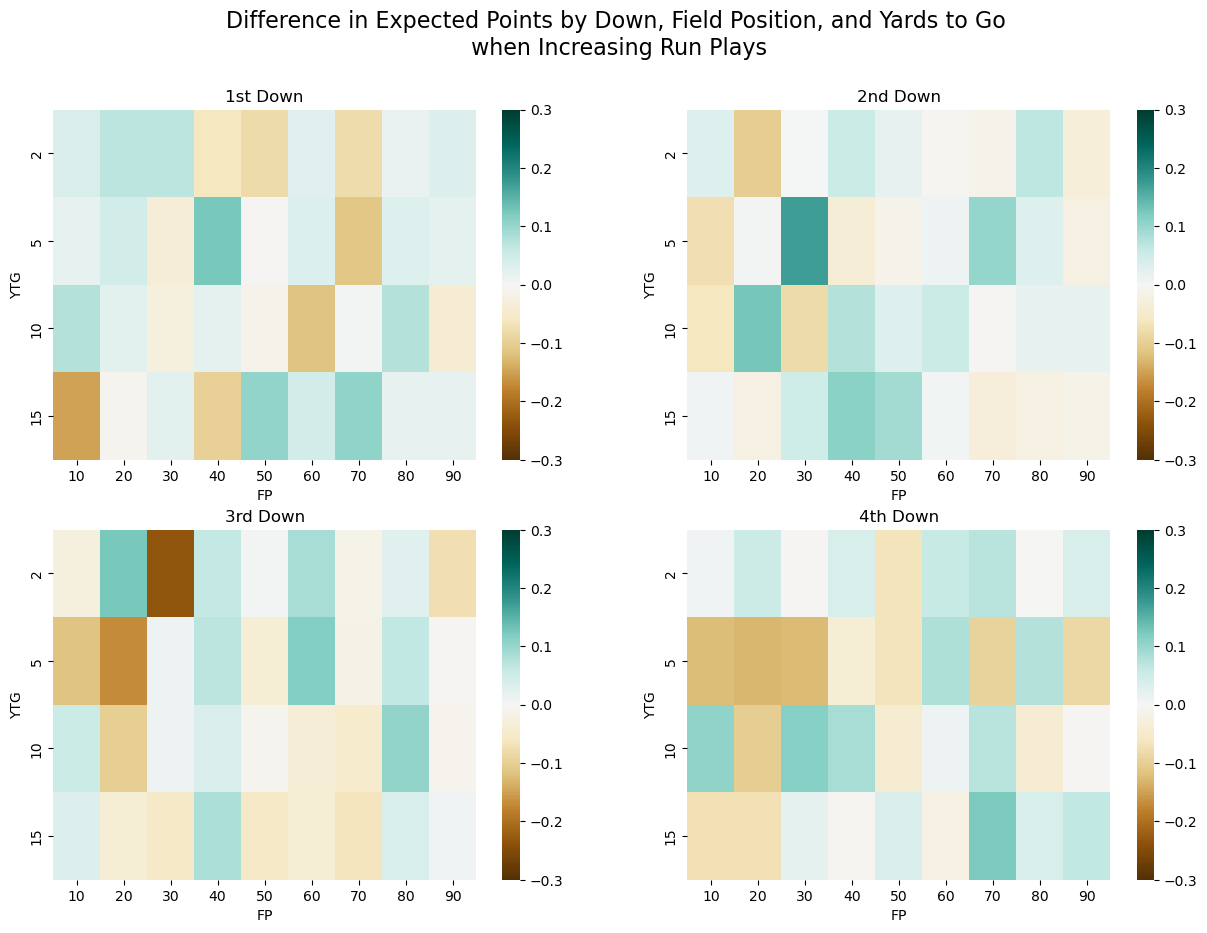

In [36]:
def ep_df_format(df, down, col):
    """Input a dataframe, the down, and a column, output the filtered df with
    the associated values for the chosen column"""
    return df[df['Down']==down].pivot(index="YTG", columns='FP', values=col)

fig1, axes1 = plt.subplots(2, 2, figsize=[15, 10])
fig1.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go\n when Increasing Run Plays', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Increase_Run'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes1[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Increase_Run'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes1[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Increase_Run'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes1[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Increase_Run'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes1[1,1]).set(title='4th Down')


[Text(0.5, 1.0, '4th Down')]

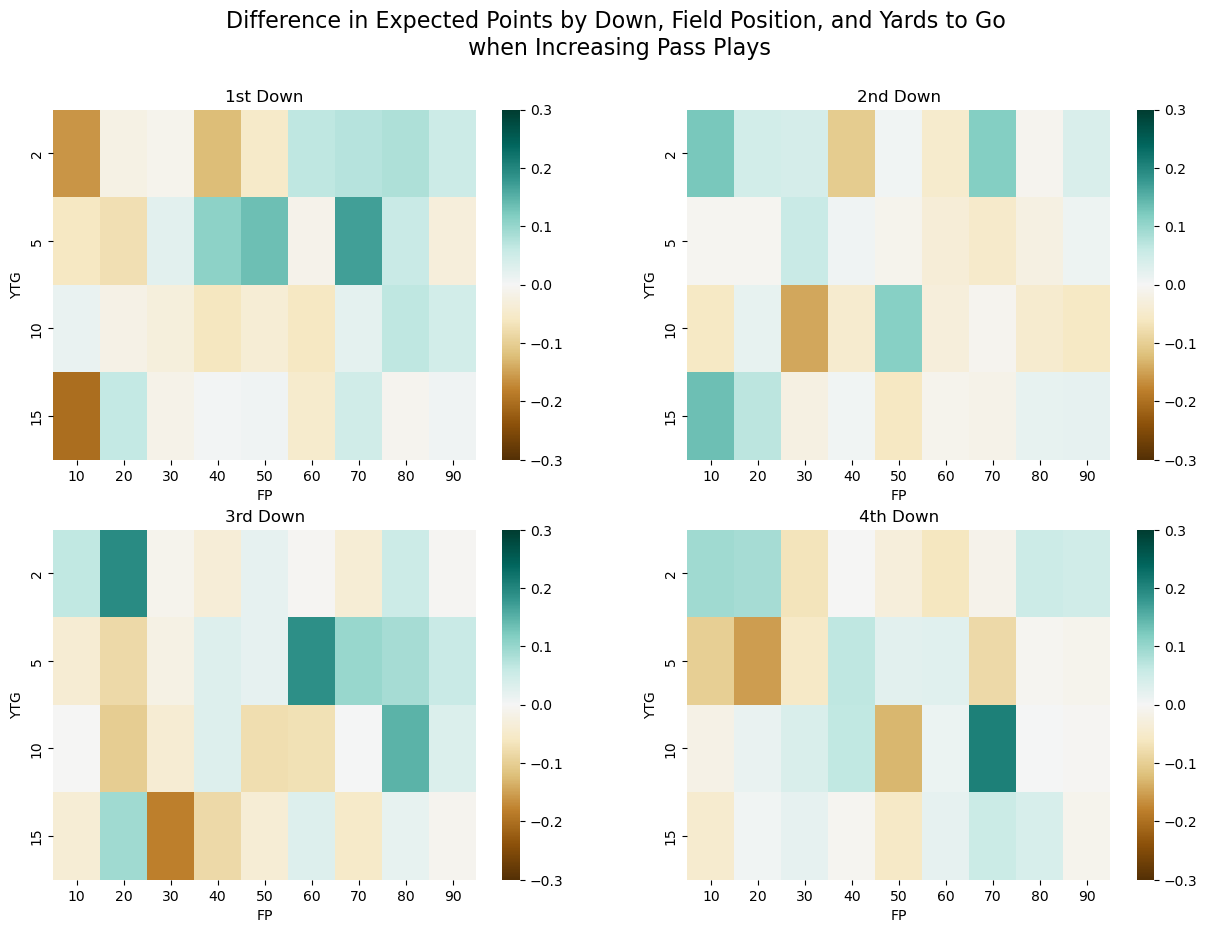

In [37]:
fig2, axes2 = plt.subplots(2, 2, figsize=[15, 10])
fig2.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go\n when Increasing Pass Plays', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Increase_Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes2[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Increase_Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes2[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Increase_Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes2[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Increase_Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes2[1,1]).set(title='4th Down')


<AxesSubplot: ylabel='Count'>

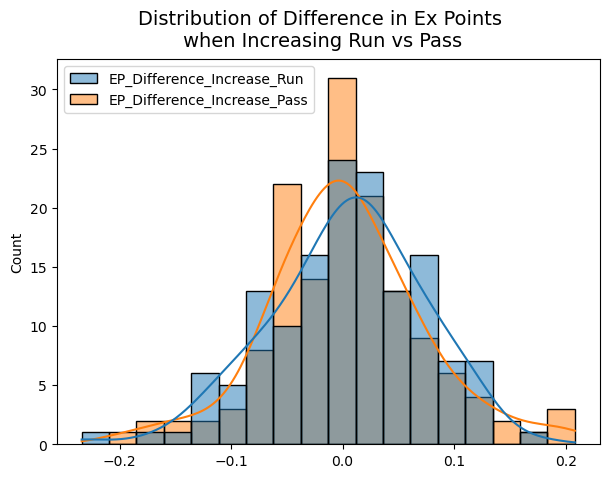

In [38]:
fig3, axes3 = plt.subplots(1, 1, figsize=[7, 5])
fig3.suptitle('Distribution of Difference in Ex Points\n when Increasing Run vs Pass', fontsize=14)
sns.histplot(ep_table_difference[['EP_Difference_Increase_Run','EP_Difference_Increase_Pass']], kde=True,
                   ax=axes3)

[Text(0.5, 1.0, '4th Down')]

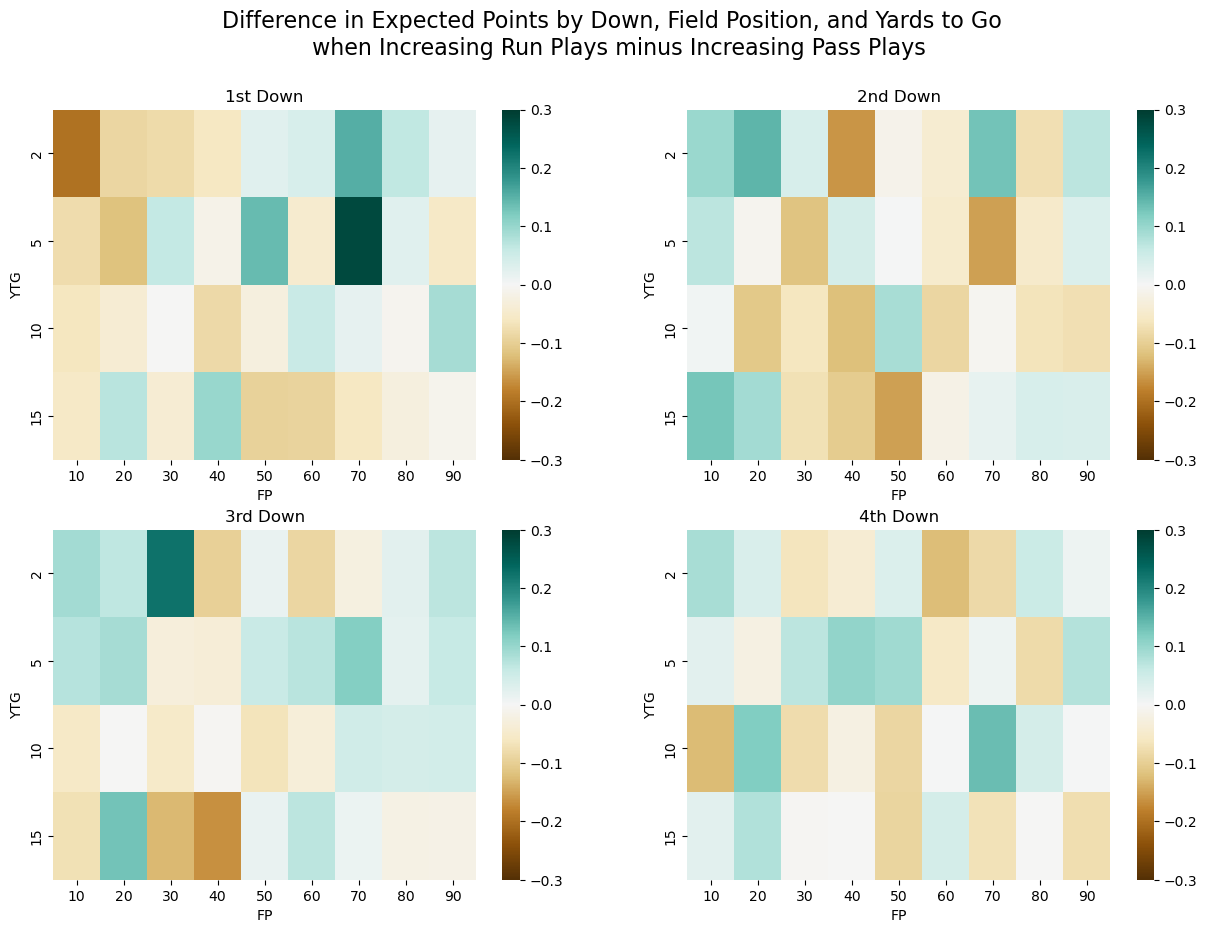

In [35]:
fig4, axes4 = plt.subplots(2, 2, figsize=[15, 10])
fig4.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go \n when Increasing Run Plays minus Increasing Pass Plays', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Run-Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes4[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Run-Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes4[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Run-Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes4[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Run-Pass'),
            vmin=-0.3, vmax=0.3, cmap='BrBG', ax=axes4[1,1]).set(title='4th Down')

In [39]:
#Save the graphs
fig1.savefig('EP Run Visualization.png', dpi=400)
fig2.savefig('EP Pass Visualization.png', dpi=400)
fig3.savefig('EP Run-Pass Histogram.png', dpi=400)
fig4.savefig('EP Run-Pass Heatmap.png', dpi=400)